In [309]:
library(tidyverse)
options(repr.plot.width=10, repr.plot.height=6)
httr::set_config(config(ssl_verifypeer = 0L))
# -k means don't verify cert, -L means follow redirects (important for some servers)
options(download.file.method="curl", download.file.extra="-k -L")
theme_set(theme_minimal())

# STATS 504
## Week 4: TransStats data

## TransStats
- [U.S. Bureau of Transportation Statistics](http://www.transtats.bts.gov)
- Aviation, maritime, highway, transit, and rail.
- We will focus on aviation today

## Three question for lecture
For today's lecture I want to answer the following questions:

- Which airlines are likely to cancel a flight (during spring break)?
- Where do people fly to from Detroit in the winter?
- What are the busiest routes?

## Getting the data
- The web site has interactive query builders for the different data bases.
- Example: [airline on-time data](https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r%FDb0-gvzr%FDcr4s14zn0pr%FDQn6n&QO_fu146_anzr=b0-gvzr)
- The interface lets you download one month of data at a time -- how to automate?

In [449]:
base <- 'https://www.transtats.bts.gov/PREZIP/'
template <- paste0(base, 'On_Time_Reporting_Carrier_On_Time_Performance_1987_present_{year}_{month}.zip')
template %>% str_glue(year=2023, month=5)

https://www.transtats.bts.gov/PREZIP/On_Time_Reporting_Carrier_On_Time_Performance_1987_present_2023_5.zip

In [100]:
## Downloading a data file
template %>% str_glue(year=2023, month=5) %>% download.file("2023_5.zip")
read_csv("2023_5.zip") -> df

Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2023_5.csv'
New names:
• `` -> `...110`
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 579958 Columns: 110
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (27): Reporting_Airline, IATA_CODE_Reporting_Airline, Tail_Number, Orig...
dbl  (49): Year, Quarter, Month, DayofMonth, DayOfWeek, DOT_ID_Reporting_Air...
lgl  (33): Div2Airport, Div2AirportID, Div2AirportSeqID, Div2WheelsOn, Div2T...
date  (1): FlightDate

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


## Assembling the dataset
Let's download all the data from 2022 (the most recent complete year).


Each `.zip` file contains a README describing the column layout. From this, I build the following column specification to extract only the data I need:

In [303]:
columns <- cols_only(
  FlightDate = col_datetime(),
  Tail_Number = col_character(),
  Reporting_Airline = col_character(),
  Origin = col_character(),
  Dest = col_character(),
  DepTime = col_double(),
  DepDelay = col_double(),
  ArrTime = col_double(),
  ArrDelay = col_double(),
  Cancelled = col_double(),
  CancellationCode = col_character(),
  AirTime = col_double(),
  Distance = col_double(),
  CarrierDelay = col_double(),
  WeatherDelay = col_double(),
  NASDelay = col_double(),
  SecurityDelay = col_double(),
  LateAircraftDelay = col_double()
)

(This is an example where ChatGPT is useful.)

## Data download function
- Now I want to download the data for 2022-1, 2022-2, ..., 2022-12 in succession and paste them together.
- Since we're going to be applying the same code twelve different times, it makes sense to package this code up into a function and re-use it.
- Guiding principle: don't repeat yourself! ([DRY](https://en.wikipedia.org/wiki/Don%27t_repeat_yourself))

In [463]:
dl_data <- function(month, year) {
    fn <- paste0(year, "_", month, ".zip")
    if (! file.exists(fn)) {
        str_glue(template, year=year, month=month) %>% download.file(fn)
    }
    read_csv(fn, col_types = columns)
}

In [468]:
flights_2022 <- 1:12 %>% purrr::map(dl_data, year = 2022, .progress = T) %>% list_rbind

Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_1.csv'
New names:
• `` -> `...110`
 ■■■                                8% |  ETA: 37s
Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_2.csv'
New names:
• `` -> `...110`
 ■■■■■■                            17% |  ETA: 32s
Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_3.csv'
New names:
• `` -> `...110`
 ■■■■■■■■■                         25% |  ETA: 31s
Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_4.csv'
New names:
• `` -> `...110`
 ■■■■■■■■■■■                       33% |  ETA: 27s
Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1987_present)_2022_5.csv'
New names:
• `` -> `...110`
 ■■■■■■■■■■■■■                     42% |  ETA: 24s
Multiple files in zip: reading 'On_Time_Reporting_Carrier_On_Time_Performance_(1

In [469]:
save(flights_2022, file="flights_2022.RData")

In [ ]:
# If you are running on Colab, you can use the following command to load the table:
# load(url('https://github.com/terhorst/stats504/lectures/week4/flights_2022.RData'))

## Who is most likely to cancel flights

- I am worried about my flight getting cancelled. Which air carrier is most likely to cancel?
- How should we we measure? Ideas:
    - Total Cancellations / Total Scheduled Flights.
    - Some cancellations are due to circumstances beyound the carrier's control (e.g. weather). 
    - Route specific cancellations: are some routes more likely to get cancelled?
    - Benchmark: compare an airline's cancellation rate against the industry average.

In [310]:
flights_2022 %>% summary

   FlightDate                     Reporting_Airline  Tail_Number       
 Min.   :2022-01-01 00:00:00.00   Length:6729125     Length:6729125    
 1st Qu.:2022-04-05 00:00:00.00   Class :character   Class :character  
 Median :2022-07-03 00:00:00.00   Mode  :character   Mode  :character  
 Mean   :2022-07-02 23:07:09.10                                        
 3rd Qu.:2022-09-30 00:00:00.00                                        
 Max.   :2022-12-31 00:00:00.00                                        
                                                                       
    Origin              Dest              DepTime          DepDelay     
 Length:6729125     Length:6729125     Min.   :   1     Min.   : -96.0  
 Class :character   Class :character   1st Qu.: 914     1st Qu.:  -5.0  
 Mode  :character   Mode  :character   Median :1324     Median :  -2.0  
                                       Mean   :1334     Mean   :  12.6  
                                       3rd Qu.:1745     3rd

## Basic analysis
Let us start by analyzing the overall cancellation rate.

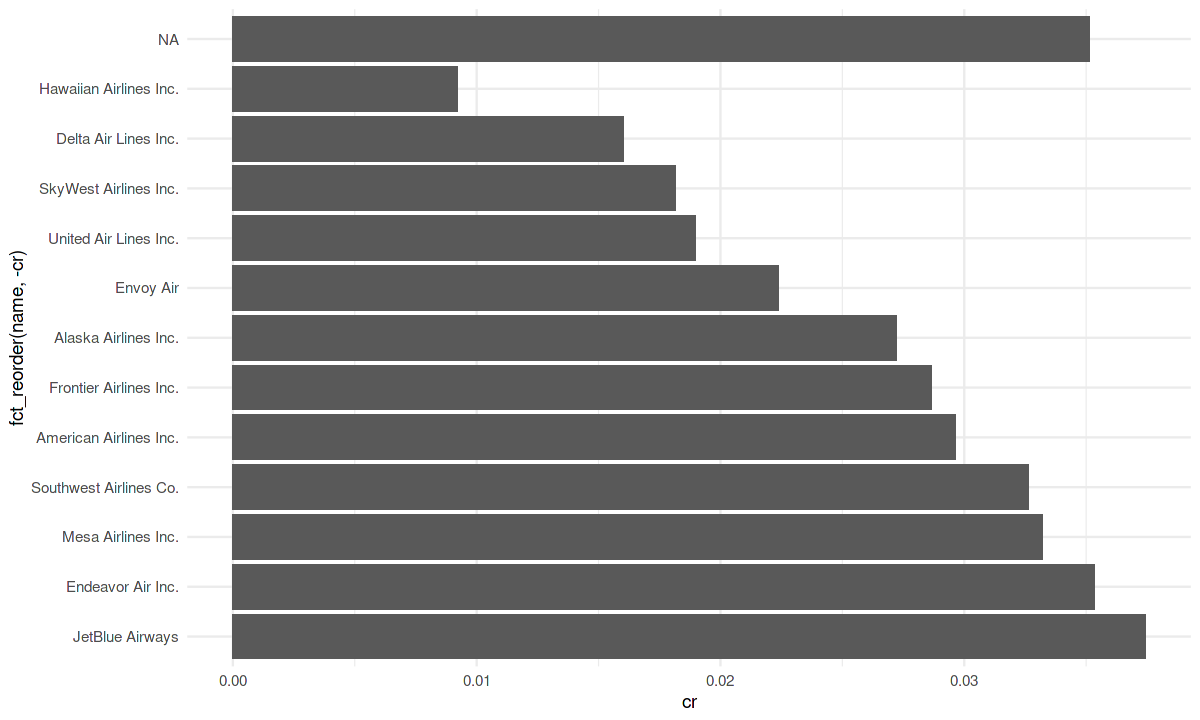

In [473]:
flights_2022 %>%
    left_join(nycflights13::airlines, join_by(Reporting_Airline == carrier)) %>% 
    group_by(name) %>% summarize(cr = mean(Cancelled)) %>% 
    ggplot + geom_col(aes(x = fct_reorder(name, -cr), y = cr)) + coord_flip()


This has revealed a problem in our data. The join did not perform as we expected.

In [474]:
flights_2022 %>%
    left_join(nycflights13::airlines, join_by(Reporting_Airline == carrier)) %>% 
    filter(is.na(name)) %>% count(Reporting_Airline)

Reporting_Airline,n
<chr>,<int>
G4,116877
NK,232400
OH,214450
QX,88791
YX,316524


Incidentally, this is an argument for using `left_join` instead of `inner_join`. Inner join would have silently eliminated all the non-matching rows. We would have no idea that we were missing out on hundreds of thousands of flights.

## Scraping
We need a quick way to get an up-to-date database of airline codes.
- Wikipedia has a list [here](https://en.wikipedia.org/wiki/List_of_airline_codes).
- How can we get this into R?

In [476]:
airline_codes <- read_html('https://en.wikipedia.org/wiki/List_of_airline_codes') %>% html_table %>% .[[1]] %>% 
    filter(IATA != "") %>% print

# A tibble: 1,513 × 6
   IATA  ICAO  Airline                     `Call sign` `Country/Region` Comments
   <chr> <chr> <chr>                       <chr>       <chr>            <chr>   
 1 PR    BOI   2GO                         ABAIR       Philippines      ""      
 2 1A    n/a   Amadeus IT Group S.A.       n/a         Global           "GDS an…
 3 1B    n/a   Sabre travel network Asia-… n/a         APAC             "Region…
 4 1E    n/a   Travelsky                   n/a         China            "Local …
 5 1F    n/a   Infini travel information,… n/a         Japan            "Local …
 6 1G    n/a   Travelport (Galileo core)   n/a         Global           "GDS (C…
 7 1H    n/a   Sirena travel               n/a         Russia           "Local …
 8 1J    n/a   Axess international networ… n/a         Japan            "Local …
 9 1K    n/a   AIRKIOSK                    n/a         Global           "Local …
10 1M    n/a   Sirin                       n/a         Russia           "Local …
# ℹ 1,

Warning message in left_join(., airline_codes, join_by(Reporting_Airline == IATA)):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 214936 of `x` matches multiple rows in `y`.
ℹ Row 984 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


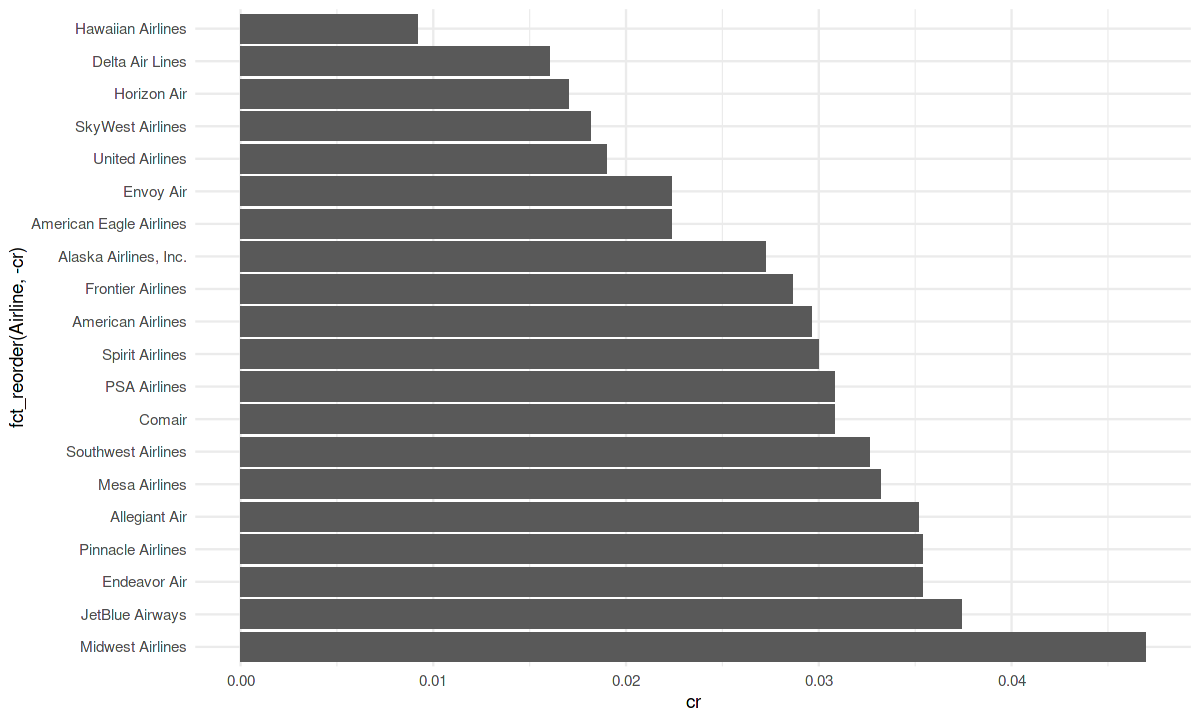

In [477]:
flights_2022 %>%
    left_join(airline_codes, join_by(Reporting_Airline == IATA)) %>% 
    group_by(Airline) %>% summarize(cr = mean(Cancelled)) %>% 
    ggplot + geom_col(aes(x = fct_reorder(Airline, -cr), y = cr)) + coord_flip()


In [376]:
airline_codes_us <- filter(airline_codes, `Country/Region` == 'United States')
flights_2022 %>%
    left_join(airline_codes_us, join_by(Reporting_Airline == IATA)) %>% 
    group_by(Airline) %>% summarize(cr = mean(Cancelled)) %>% 
    ggplot + geom_col(aes(x = fct_reorder(Airline, -cr), y = cr)) + coord_flip()


ERROR: Error in left_join(., airline_codes_us, join_by(Reporting_Airline == IATA)): (converted from warning) [1m[22mDetected an unexpected many-to-many relationship between `x` and `y`.
[36mℹ[39m Row 214936 of `x` matches multiple rows in `y`.
[36mℹ[39m Row 133 of `y` matches multiple rows in `x`.
[36mℹ[39m If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.


In [362]:
filter(airline_codes_us, IATA == "MQ")

IATA,ICAO,Airline,Call sign,Country/Region,Comments
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
MQ,EGF,American Eagle Airlines,EAGLE FLIGHT,United States,"Renamed Envoy Air, ICAO Code and Callsign withdrawn in 2014"
MQ,ENY,Envoy Air,ENVOY,United States,2014[22]


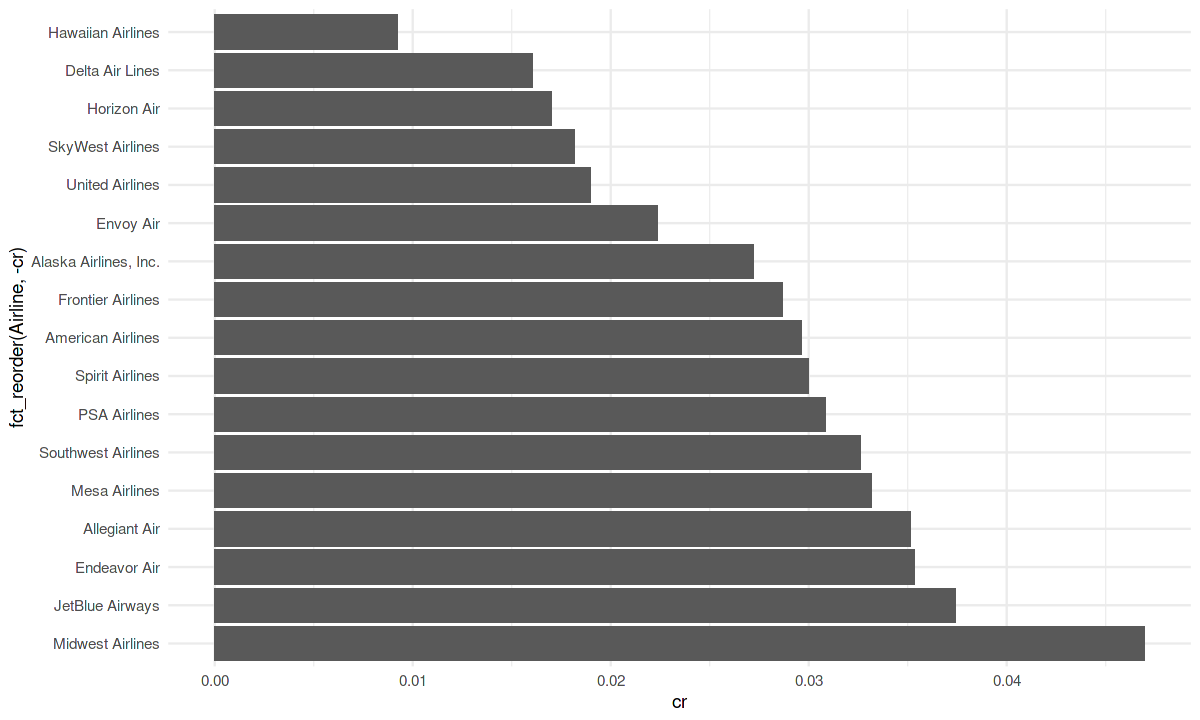

In [375]:
airline_codes_us %>% filter(! ICAO %in% c("COM", "EGF", "FLG")) -> ac_us_filt
flights_2022 %>%
    left_join(ac_us_filt, join_by(Reporting_Airline == IATA)) %>% 
    group_by(Airline) %>% summarize(cr = mean(Cancelled)) %>% 
    ggplot + geom_col(aes(x = fct_reorder(Airline, -cr), y = cr)) + coord_flip()

## Cancellation rate by week
- Let's consider cancellations by week of the year.
- Are cancellations more likely during some periods of the year than others?

`summarise()` has grouped output by 'wk'. You can override using the `.groups` argument.


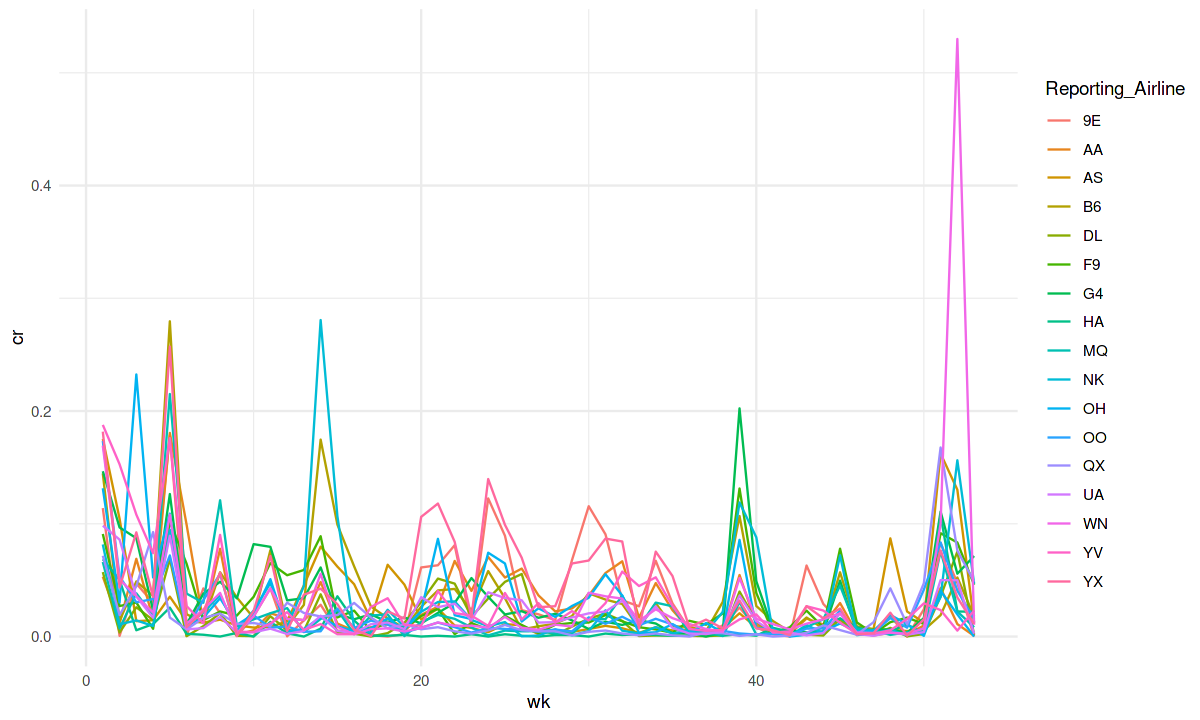

In [313]:
flights_2022 %>% mutate(wk = lubridate::week(FlightDate)) %>% 
    group_by(wk, Reporting_Airline) %>% summarize(cr = mean(Cancelled)) %>% 
    ggplot + geom_line(aes(x = wk, y = cr, color = Reporting_Airline))

This plot is sort of hard to read, so let's think of same ways to improve it:
- Plot carrier name instead of code.
- Consider deviation from average weekly delay.

`summarise()` has grouped output by 'wk'. You can override using the `.groups` argument.


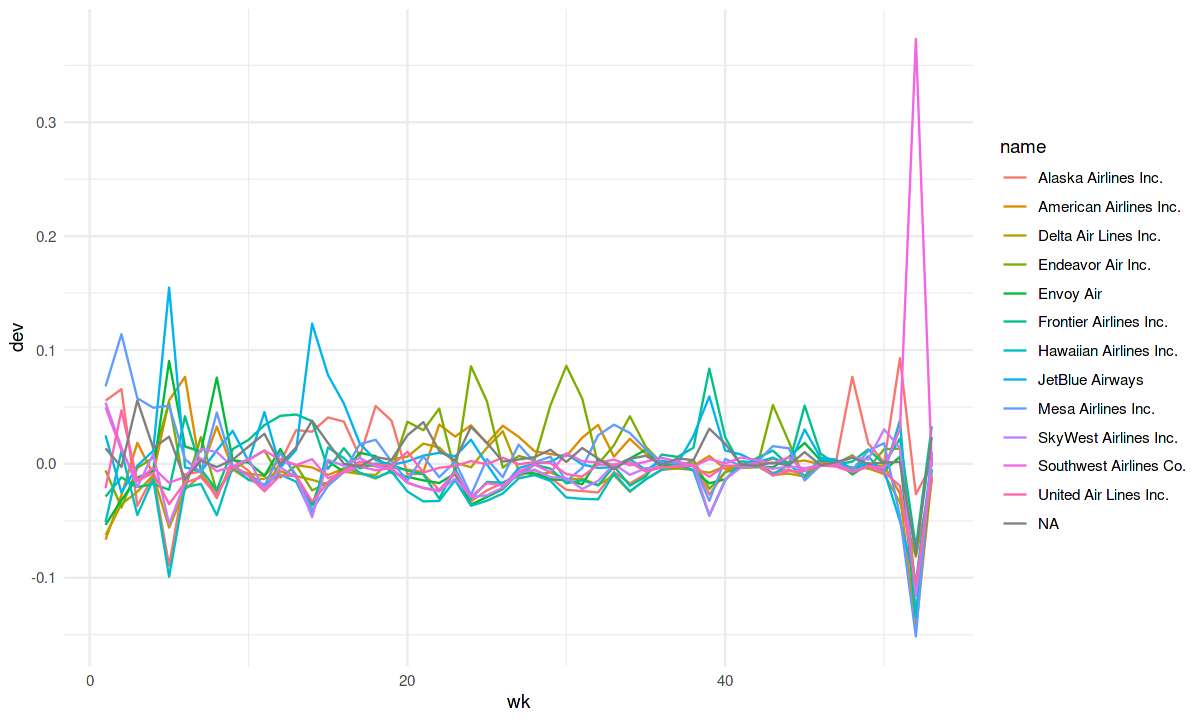

In [319]:
flights_2022 %>% mutate(wk = lubridate::week(FlightDate)) %>% 
    left_join(nycflights13::airlines, join_by(Reporting_Airline == carrier)) %>% 
    group_by(wk, name) %>% 
    summarize(cr = mean(Cancelled), nc = sum(Cancelled), n = n()) %>% 
    mutate(dev = cr - sum(nc) / sum(n)) %>% 
    ggplot + geom_line(aes(x = wk, y = dev, color = name))

(What is the [spike](https://en.wikipedia.org/wiki/2022_Southwest_Airlines_scheduling_crisis) at the very end of 2022?)

The plot is still rather jumbled. We can try zooming in on specific carriers:

In [480]:
flights_2022 %>% mutate(wk = lubridate::week(FlightDate)) %>% 
    left_join(nycflights13::airlines, join_by(Reporting_Airline == carrier)) %>% 
    group_by(wk, name) %>% 
    summarize(cr = mean(Cancelled), nc = sum(Cancelled), n = n()) %>%
    mutate(dev = cr - sum(nc) / sum(n)) %>% 
    filter(name == "Southwest Airlines Co.") -> carrier_cancellations

`summarise()` has grouped output by 'wk'. You can override using the `.groups` argument.


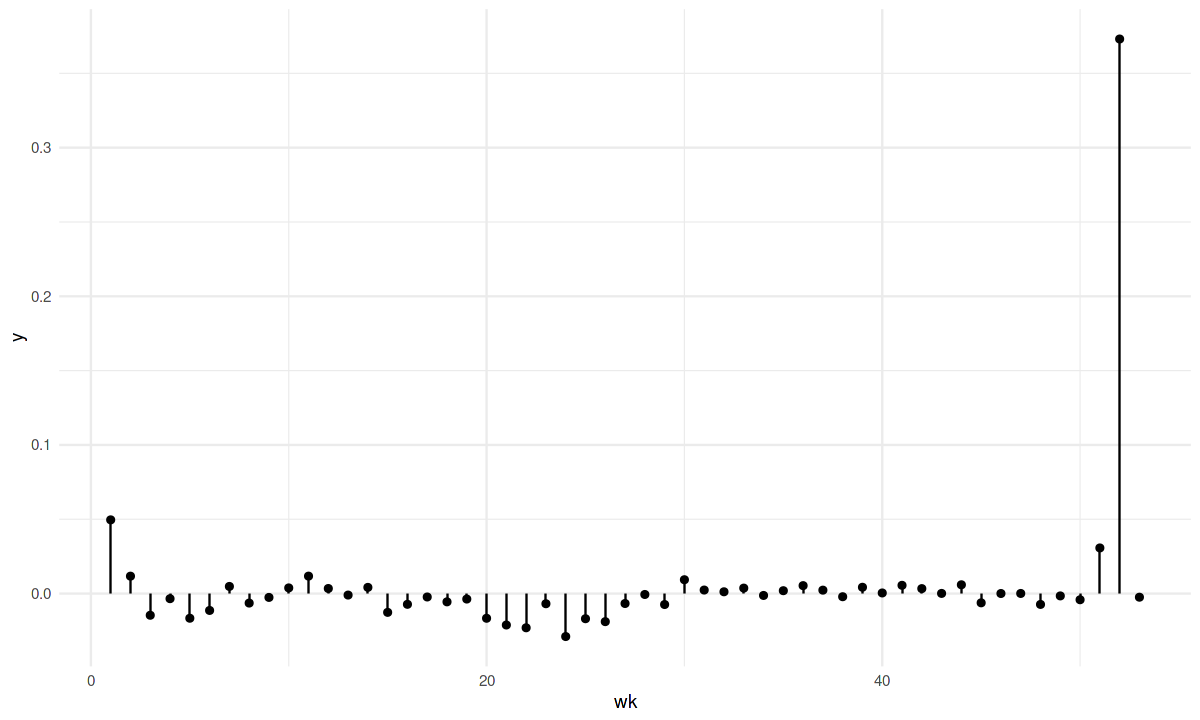

In [482]:
# lollipop plot
carrier_cancellations %>% ggplot + 
    geom_segment(aes(x = wk, xend=wk, y = 0, yend = dev)) +
    geom_point(aes(x = wk, y = dev))

## Reasons for cancellation

- For flights that are cancelled, there is a code:

In [485]:
flights_2022$CancellationCode %>% table

.
    A     B     C     D 
71780 93013 15469  1024 

- [What do the codes mean](https://www.transtats.bts.gov/FieldInfo.asp?Svryq_Qr5p=f2rpvsvr5%FDgur%FDern510%FDS14%FDPn0pryyn6v10&Svryq_gB2r=Pun4&Y11x72_gnoyr=Y_PNaPRYYNgVba&gnoyr_VQ=FGK&flf_gnoyr_anzr=g_bagVZR_ZNeXRgVaT&fB5_Svryq_anzr=PNaPRYYNgVba_PbQR)?

In [490]:
flights_2022 %>% mutate(CancellationCode = fct_recode(CancellationCode,
      Carrier = "A",
      Weather = "B",
      "National Air System" = "C",
      Security = "D"
   )
) -> flights_2022a

- Now we want to visualize the distribution of two categorical variables: `airline` and `cancellation code`.
- How should we do it?
- (Recall last lecture)

In [492]:
table(flights_2022a$Reporting_Airline, flights_2022a$CancellationCode) -> fl_tbl
fl_tbl

    
     Carrier Weather National Air System Security
  9E    1953    3075                3174        0
  AA    8839   15744                1309        2
  AS    5132    1049                  36        1
  B6    4655    3976                1588        0
  DL    8359    4991                 967        0
  F9    2232    2223                   0        0
  G4    1973    1820                 303       14
  HA     635      45                   0        0
  MQ     785    3884                 881        0
  NK    1630    5081                 262        0
  OH    1231    5223                 158        0
  OO    2230   10047                 809      245
  QX     748     689                  75        0
  UA    5309    5488                 586      503
  WN   22673   17497                2373      112
  YV    1833    1607                 223      147
  YX    1563   10574                2725        0

To make the table more readable, we should normalize the table across:
    - Rows?
    - Columns?

In [496]:
fl_tbl %>% prop.table(1) %>% round(2)

    
     Carrier Weather National Air System Security
  9E    0.24    0.37                0.39     0.00
  AA    0.34    0.61                0.05     0.00
  AS    0.83    0.17                0.01     0.00
  B6    0.46    0.39                0.16     0.00
  DL    0.58    0.35                0.07     0.00
  F9    0.50    0.50                0.00     0.00
  G4    0.48    0.44                0.07     0.00
  HA    0.93    0.07                0.00     0.00
  MQ    0.14    0.70                0.16     0.00
  NK    0.23    0.73                0.04     0.00
  OH    0.19    0.79                0.02     0.00
  OO    0.17    0.75                0.06     0.02
  QX    0.49    0.46                0.05     0.00
  UA    0.45    0.46                0.05     0.04
  WN    0.53    0.41                0.06     0.00
  YV    0.48    0.42                0.06     0.04
  YX    0.11    0.71                0.18     0.00

## Where do people in Michigan fly during the winter?

To study this, we will use a random 10% sample of all airline tickets issued during Q12023:

https://www.transtats.bts.gov/DatabaseInfo.asp?QO_VQ=EFI&Yv0x=D

In [155]:
tkt_2023 <- read_csv('Origin_and_Destination_Survey_DB1BMarket_2023_1.zip') 

Multiple files in zip: reading 'Origin_and_Destination_Survey_DB1BMarket_2023_1.csv'
New names:
• `` -> `...42`
Rows: 6714113 Columns: 42
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (17): Origin, OriginCountry, OriginStateFips, OriginState, OriginStateNa...
dbl (24): ItinID, MktID, MktCoupons, Year, Quarter, OriginAirportID, OriginA...
lgl  (1): ...42

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [175]:
tkt_2023 %>% filter(Origin == "DTW") %>% count(Dest) %>%
    left_join(nycflights13::airports, join_by(Dest == faa)) ->
    dtw_winter_locations
    

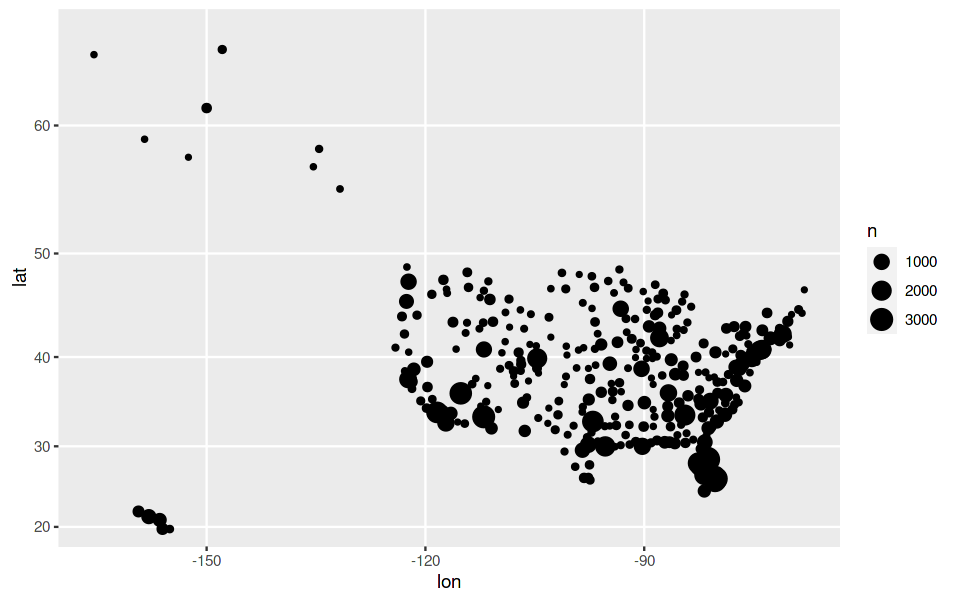

In [187]:
dtw_winter_locations %>% drop_na %>% ggplot() + geom_point(aes(x = lon, y = lat, size=n)) +
    coord_map()

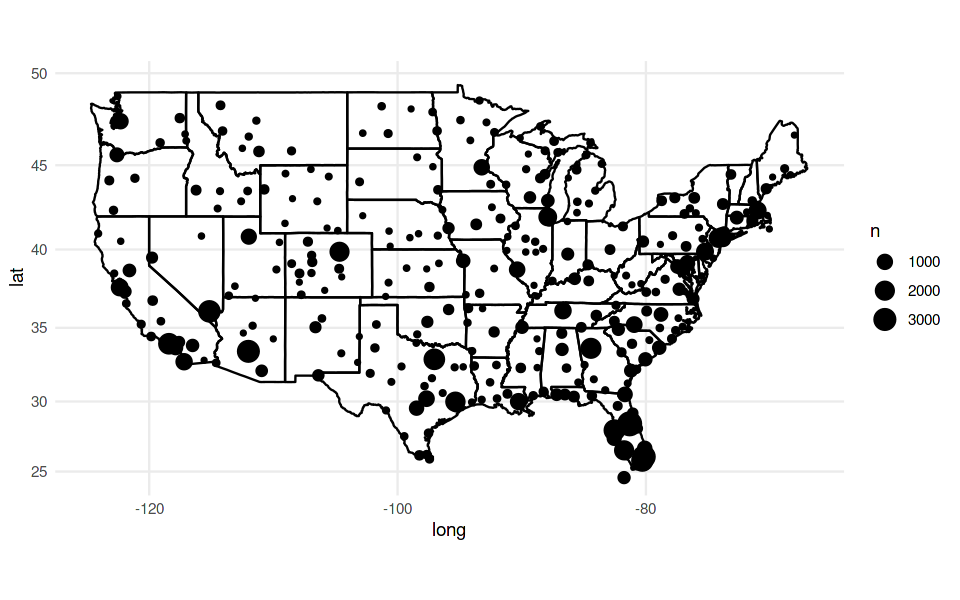

In [218]:
library(maps)
states <- map_data("state")

dtw_winter_locations %>% drop_na %>% filter(lon > -125) %>% 
    ggplot() + 
    geom_polygon(data=states, aes(x=long, y = lat, group = group), color = "black", fill = NA) +
    geom_point(aes(x = lon, y = lat, size=n)) +
    coord_map() + theme_minimal()

In [240]:
# install.packages(c('tigris', 'geojsonio'))
library(tigris)
library(sf)
states <- states(cb = TRUE)

Retrieving data for the year 2021



In [296]:
points_sf <- dtw_winter_locations %>% drop_na %>% st_as_sf(coords = c("lon", "lat"), crs = 4269)
joined_data <- st_join(states, points_sf, join = st_contains)
joined_data %>% head

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,Dest,n,name,alt,tz,dst,tzone,geometry
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<MULTIPOLYGON [°]>
1,56,01779807,0400000US56,56,WY,Wyoming,00,251458712294,1867503716,COD,1732.00,Yellowstone Rgnl,5102,-7,A,America/Denver,MULTIPOLYGON (((-111.0546 4...
1.1,56,01779807,0400000US56,56,WY,Wyoming,00,251458712294,1867503716,CPR,3313.35,Natrona Co Intl,5347,-7,A,America/Denver,MULTIPOLYGON (((-111.0546 4...
1.2,56,01779807,0400000US56,56,WY,Wyoming,00,251458712294,1867503716,CYS,1230.00,Cheyenne Rgnl Jerry Olson Fld,6156,-7,A,America/Denver,MULTIPOLYGON (((-111.0546 4...
1.3,56,01779807,0400000US56,56,WY,Wyoming,00,251458712294,1867503716,GCC,2077.06,Gillette-Campbell County Airport,4365,-7,A,America/Denver,MULTIPOLYGON (((-111.0546 4...
1.4,56,01779807,0400000US56,56,WY,Wyoming,00,251458712294,1867503716,JAC,48769.47,Jackson Hole Airport,6451,-7,A,America/Denver,MULTIPOLYGON (((-111.0546 4...
1.5,56,01779807,0400000US56,56,WY,Wyoming,00,251458712294,1867503716,LAR,234.00,Laramie Regional Airport,7284,-7,A,America/Denver,MULTIPOLYGON (((-111.0546 4...


In [297]:
joined_data %>% group_by(NAME, geometry) %>% summarize(n = sum(n)) %>% print -> 
    tkts_by_state

`summarise()` has grouped output by 'NAME'. You can override using the `.groups` argument.


Simple feature collection with 56 features and 2 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -179.1489 ymin: -14.5487 xmax: 179.7785 ymax: 71.36516
Geodetic CRS:  NAD83
# A tibble: 56 × 3
# Groups:   NAME [56]
   NAME                                                         geometry       n
   <chr>                                              <MULTIPOLYGON [°]>   <dbl>
 1 Alabama                                     (((-88.05338 30.50699, -…  2.59e5
 2 Alaska                                      (((179.4825 51.98283, 17…  8.37e4
 3 American Samoa                              (((-168.1458 -14.54791, … NA     
 4 Arizona                                     (((-114.8163 32.50804, -…  9.89e5
 5 Arkansas                                    (((-94.61792 36.49941, -…  9.91e4
 6 California                                  (((-118.6044 33.47855, -…  3.01e6
 7 Colorado                                    (((-109.0603 38.59933, -…  6.61e5
 8 Commonwealth of the Northern

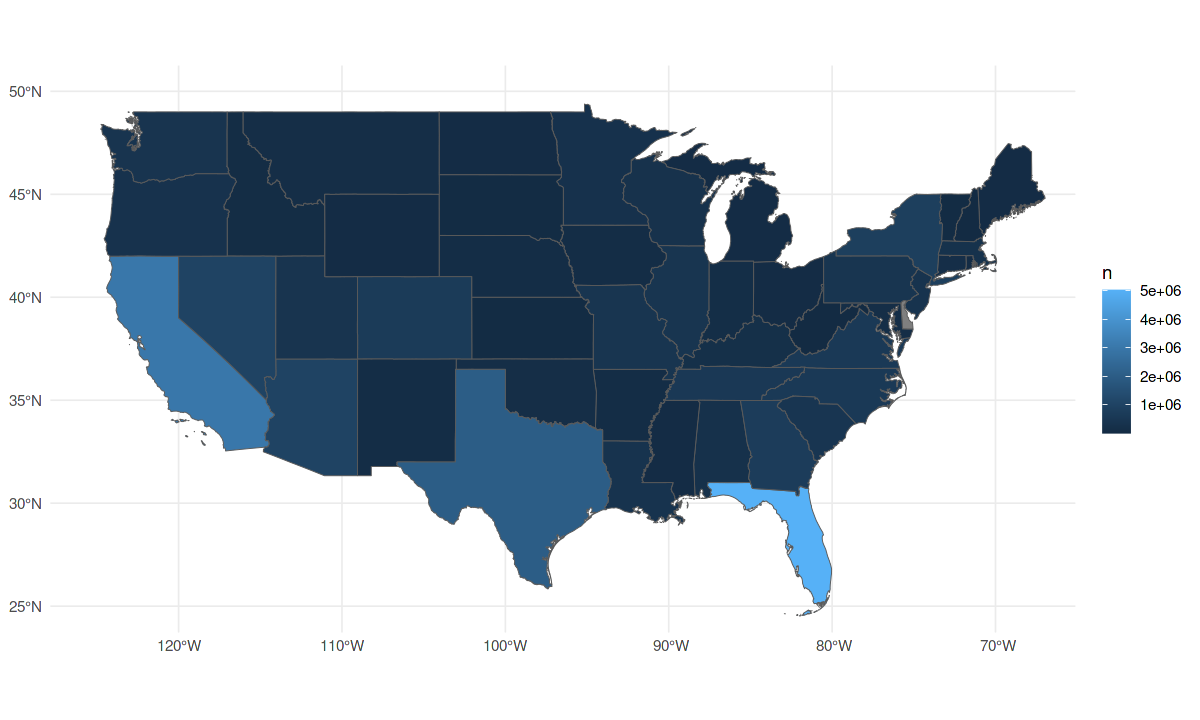

In [385]:
tkts_by_state %>% filter(NAME %in% conus) %>% ggplot + geom_sf(aes(fill = n)) +
    xlim(c(-125,-68)) + ylim(c(25, 50))

## Which routes have the most passengers?

To study this question, we will load a third database on [passenger counts (T-100)](https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FIL&QO_fu146_anzr=Nv4%20Pn44vr45).

In [389]:
t100 <- read_csv('896816367_T_T100D_MARKET_US_CARRIER_ONLY.zip')

New names:
• `` -> `...37`
Rows: 104789 Columns: 37
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (17): UNIQUE_CARRIER, UNIQUE_CARRIER_NAME, UNIQUE_CARRIER_ENTITY, REGION...
dbl (19): PASSENGERS, FREIGHT, MAIL, DISTANCE, AIRLINE_ID, CARRIER_GROUP, CA...
lgl  (1): ...37

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [392]:
head(t100)

PASSENGERS,FREIGHT,MAIL,DISTANCE,UNIQUE_CARRIER,AIRLINE_ID,UNIQUE_CARRIER_NAME,UNIQUE_CARRIER_ENTITY,REGION,CARRIER,⋯,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS,...37
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>
0,32335,0,56,1SQ,21570,Star Marianas Air Inc.,01169,D,1SQ,⋯,TT,75,U.S. Pacific Trust Territories and Possessions,5,2015,1,1,1,L,NA
0,23477,0,56,1SQ,21570,Star Marianas Air Inc.,01169,D,1SQ,⋯,TT,75,U.S. Pacific Trust Territories and Possessions,5,2015,1,1,1,L,NA
0,0,0,10,2E,20319,Smokey Bay Air Inc.,06971,D,2E,⋯,AK,02,Alaska,1,2015,1,1,1,F,NA
0,0,4,88,2O,20443,Island Air Service,06981,D,2O,⋯,AK,02,Alaska,1,2015,1,1,1,F,NA
0,0,162,24,2O,20443,Island Air Service,06981,D,2O,⋯,AK,02,Alaska,1,2015,1,1,1,F,NA
0,0,25,24,2O,20443,Island Air Service,06981,D,2O,⋯,AK,02,Alaska,1,2015,1,1,1,F,NA


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


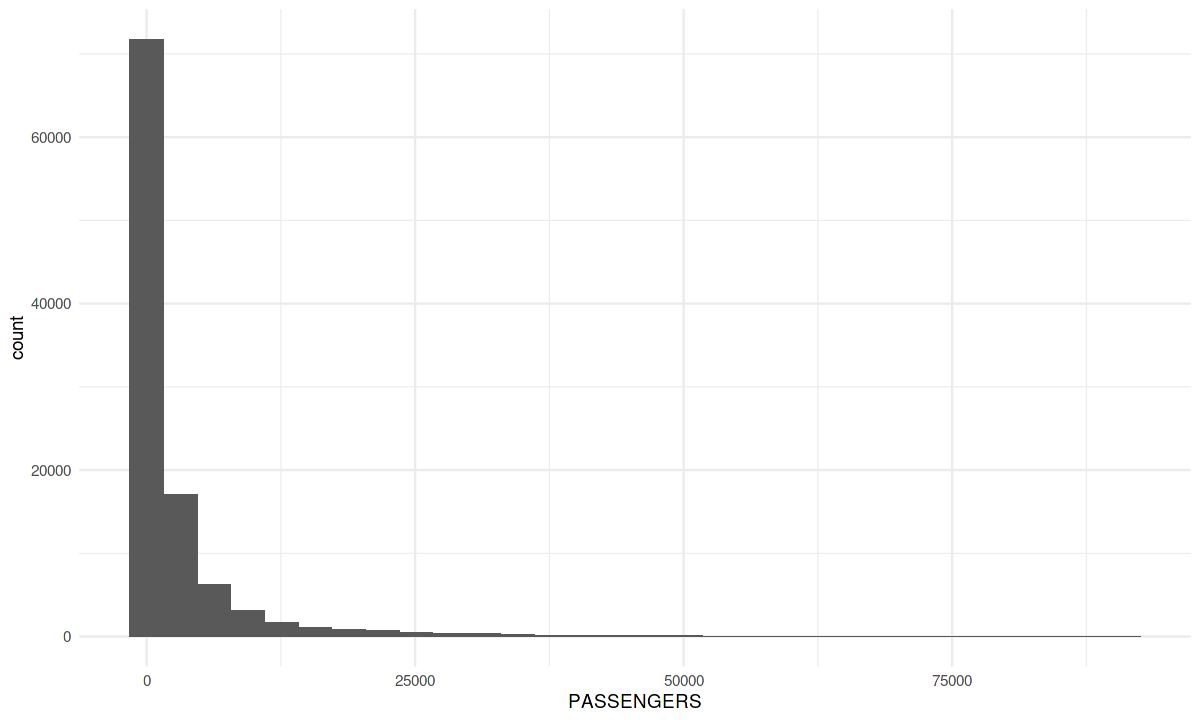

In [391]:
ggplot(t100) + geom_histogram(aes(x = PASSENGERS))

In [423]:
library(nycflights13)
t100 %>% group_by(ORIGIN, DEST) %>% summarize(tp = sum(PASSENGERS)) %>% 
    ungroup %>%  top_n(20, tp) %>% 
    left_join(airports, join_by(ORIGIN == faa)) %>% 
    left_join(airports, join_by(DEST == faa)) -> t100_top

`summarise()` has grouped output by 'ORIGIN'. You can override using the `.groups` argument.


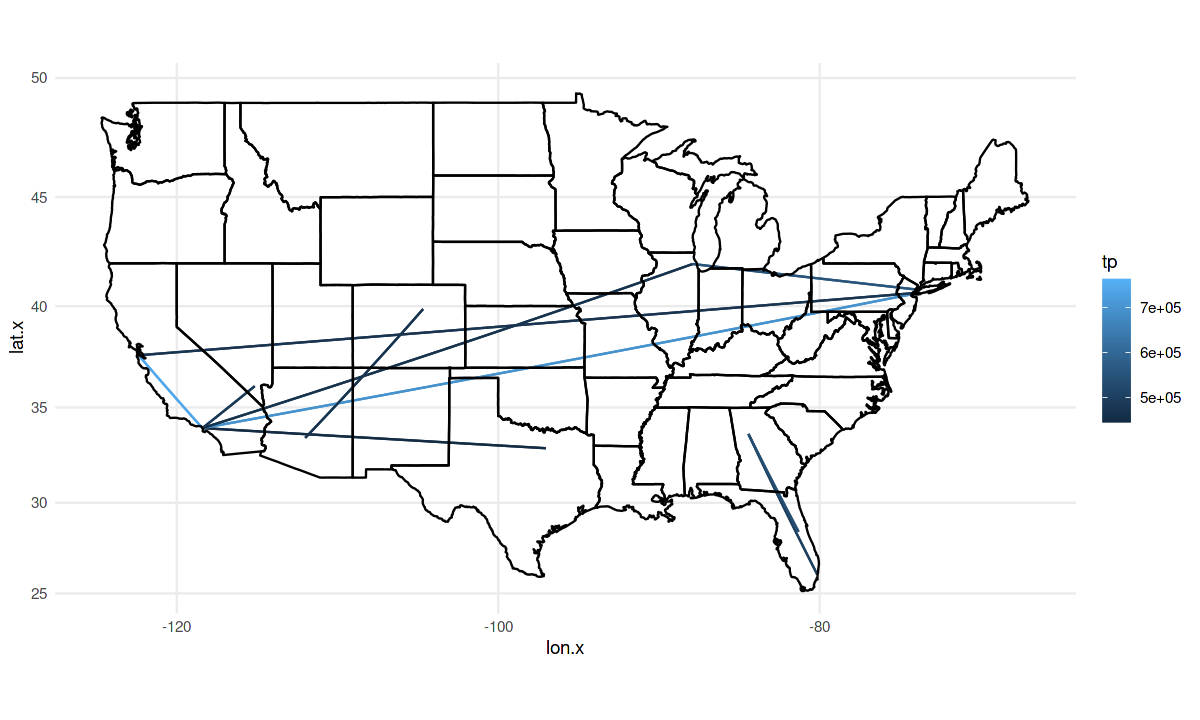

In [427]:
t100_top %>% ggplot + geom_segment(aes(x = lon.x, xend = lon.y, y = lat.x, yend = lat.y, color=tp)) +
    geom_polygon(data = map_data('state'), aes(x = long, y = lat, group = group), fill = NA, color = "black") + 
    coord_map()

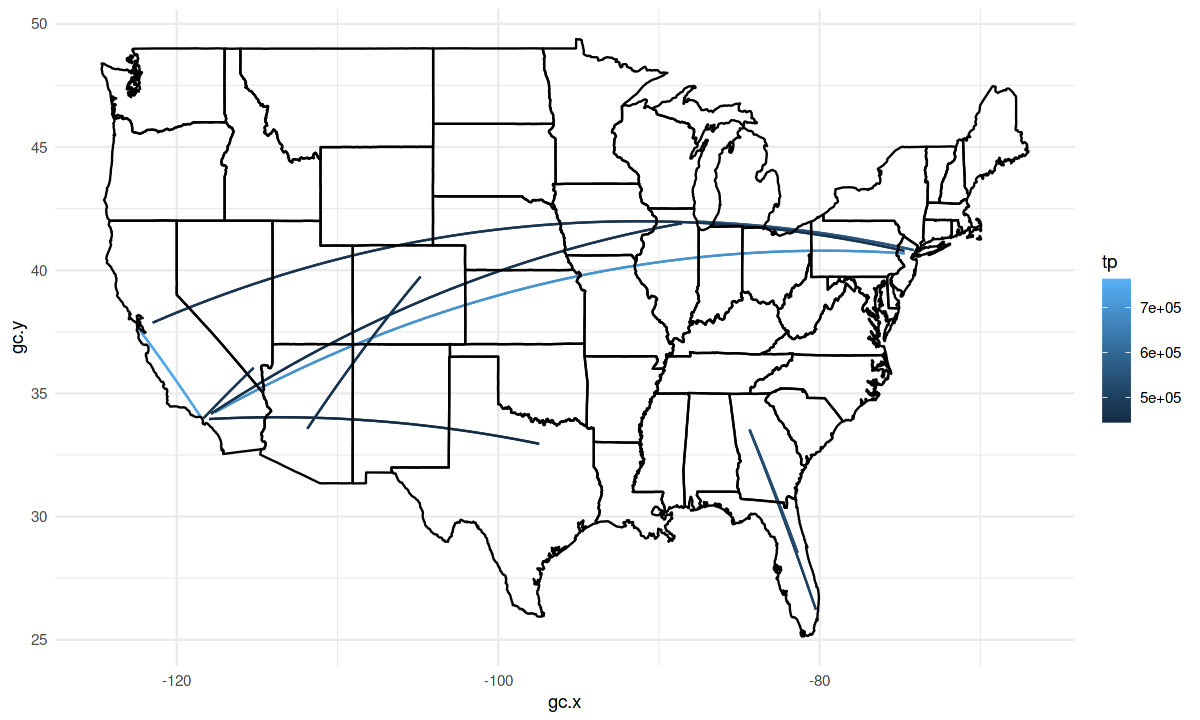

In [447]:
library(geosphere)
t100_top %>% mutate(ident = row_number()) %>% rowwise() %>% mutate(gc = list(gcIntermediate(c(lon.x, lat.x), c(lon.y, lat.y)))) %>% 
    unnest(gc) %>% mutate(gc.x = gc[,1], gc.y = gc[,2])  %>% 
    ggplot + geom_line(aes(x = gc.x, y = gc.y, group = ident, color = tp)) + 
    geom_polygon(data = map_data('state'), aes(x = long, y = lat, group = group), fill = NA, color = "black")